In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/repositories/covid19_synthesis/

/content/drive/My Drive/repositories/covid19_synthesis


In [ ]:
from nbdev_c19_synthesis.c19_synthesis.core import *
from nbdev_c19_synthesis.c19_synthesis.cellular_automata import *

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import binary_erosion, binary_dilation, binary_fill_holes
from scipy import ndimage
import os

In [ ]:
from sklearn.cluster import DBSCAN
from copy import copy
from scipy.ndimage import binary_closing
from scipy.ndimage import distance_transform_bf

In [ ]:
import torch
import torch.nn.functional as F
from time import time
from IPython.display import Image, HTML, clear_output

In [ ]:
import imageio
import os
import moviepy.editor as mvp
from pathlib import Path
from tqdm.notebook import tqdm
from skimage.restoration import inpaint

In [ ]:
%load_ext autoreload
%autoreload 2

# Project name here

> Summary description here.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## get lungs and cluster lesions

Fill me in please! Don't forget code examples:

In [ ]:
# read files
filename = 'covid19-A-0003_ct.nii.gz'
path_source = '/content/drive/My Drive/Datasets/covid19/COVID-19-20_v2/'
path_dest = '/content/drive/My Drive/KCL/covid19/inpainting_results/'
# load ct, normalize, rotate, 
ct, ct_mask, ct_seg = read_covid_CT_and_mask(path_source, filename)
ct, ct_mask, ct_seg = normalize_rotate(ct, ct_mask, ct_seg)
ct_small, ct_mask_small, ct_seg_small = ct, ct_mask, ct_seg
labelled, nr = label(ct_seg_small>0)
largest_component = (labelled == (np.bincount(labelled.flat)[1:].argmax() + 1))
# find the two lungs
ERODE_ITER = 5
ct_seg_erod = binary_erosion(ct_seg_small>0, iterations=ERODE_ITER)
lab, nr = label(ct_seg_erod)
lab_areas = np.array(ndimage.sum(ct_seg_erod, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 500000
two_lungs = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
two_lungs, nr = label(two_lungs)
assert nr == 2
# masks
bkgd = ct_seg_small == 0
target_mask = np.logical_or(bkgd,ct_mask_small)
target_mask = ~target_mask #lungs without lesions
target_mask2 = ~bkgd # lungs with lesions
target_mask3 = ct_mask_small.astype(bool) #lesions only
SLICE=100
# get largest lesion using label
lab, nr_ = label(target_mask3)
lab_areas = np.array(ndimage.sum(target_mask3, lab, np.arange(lab.max()+1)))
mask_small_lab_areas = lab_areas > 5000
one_big_lesion = mask_small_lab_areas[lab.ravel()].reshape(lab.shape)
lab, nr_ = label(one_big_lesion)
# get dimensions of one_big_lesion and find one_big_lesion is in left or right lung 
y_min_lesion, y_max_lesion, x_min_lesion, x_max_lesion, z_min_lesion, z_max_lesion = get_min_max(one_big_lesion)
for i in [1,2]:
  y_min, y_max, x_min, x_max, z_min, z_max = get_min_max(two_lungs, LABEL=i)
  if y_min_lesion >= y_min and y_max_lesion <= y_max and x_min_lesion >= x_min and x_max_lesion <= x_max and z_min_lesion >= z_min and z_max_lesion <= z_max:
    coords_lung_inpaint = y_min, y_max, x_min, x_max, z_min, z_max
lung_inpaint = ct_seg_small[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
lung_one_big_lesion = one_big_lesion[coords_lung_inpaint[0]:coords_lung_inpaint[1],coords_lung_inpaint[2]:coords_lung_inpaint[3],coords_lung_inpaint[4]:coords_lung_inpaint[5]]
# pad each dimension to length multiple of 32 (needed for inpainting, maye not anymore)
mask_inpain = ~(lung_one_big_lesion + (lung_inpaint==0))
img = pad_two_size_multiple_32(lung_inpaint)
mask_inpain = pad_two_size_multiple_32(mask_inpain)
lung_one_lesion = pad_two_size_multiple_32(lung_inpaint, lung_one_big_lesion)
# get the lung with the lesion
target_img_covid = img * lung_one_lesion
y_min, y_max, x_min, x_max, z_min, z_max =  get_min_max(lung_one_lesion)
target_img_covid = target_img_covid[y_min: y_max, x_min: x_max, z_min: z_max]
SLICE = 50
im = copy(target_img_covid[...,SLICE])

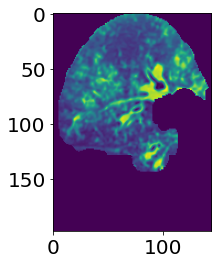

In [ ]:
plt.imshow(im)

In [ ]:
path_synthesis = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient04/'
all_files = os.listdir(path_synthesis)
lesion_files = [i for i in all_files if i.startswith('lesion')]
coords_files = [i for i in all_files if i.startswith('coords_lesion')]
masks_files = [i for i in all_files if i.startswith('mask_lesion')]
# read lesions and coordinates making sure both files exist
lesions_all = []
coords_all = []
masks_all = []
lesion_nr = []
possible_lesions = np.arange(np.max((len(lesion_files), len(coords_files),len(masks_files))))
for i in possible_lesions:
  if f'lesion_{i}.npz' in lesion_files and f'coords_lesion_{i}.npy' in coords_files and f'mask_lesion_{i}.npz' in masks_files:
    lesion_ = np.load(f'{path_synthesis}lesion_{i}.npz')
    lesions_all.append(lesion_.f.arr_0)
    coords_all.append(np.load(f'{path_synthesis}coords_lesion_{i}.npy'))
    mask_ = np.load(f'{path_synthesis}mask_lesion_{i}.npz')
    masks_all.append(mask_.f.arr_0)
    lesion_nr.extend([i])
print(len(lesions_all), len(coords_all), len(masks_all))
lesion_nr

16 16 16


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
path_synthesis_old = '/content/drive/My Drive/Datasets/covid19/results/cea_synthesis/patient0/'
texture_orig = np.load(f'{path_synthesis_old}texture.npy.npz')
texture_orig = texture_orig.f.arr_0
texture = texture_orig + np.abs(np.min(texture_orig)) + .07

-0.48188075 0.07


(0.0, 1.0)

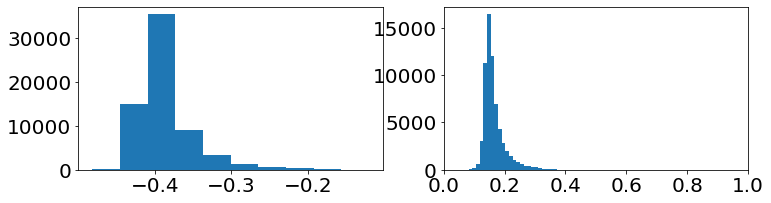

In [ ]:
print(np.min(texture_orig), np.min(texture))
fig, ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(texture_orig.flatten());
# ax[0].set_xlim([0,1])
ax[1].hist(texture.flatten(), bins=30);
ax[1].set_xlim([0,1])

## blend test

(0.0, 1.0)

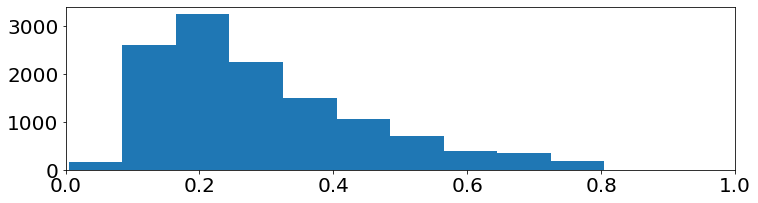

In [ ]:
plt.figure(figsize=(12,3))
plt.hist(target_img_covid[target_img_covid[...,SLICE]>0,SLICE]);
plt.xlim([0,1])

(15, 16) (15, 16)


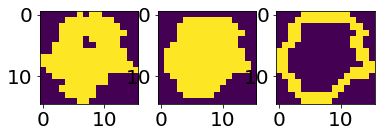

In [ ]:
GEN = 10
iter_erosion_dilation = 1
for idx_, (lesion, coord, mask) in enumerate(zip(lesions_all, coords_all, masks_all)):
  if idx_ == 0:continue
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  mask_closed = binary_closing(mask)
  mask_in = (mask_closed).astype('int') - binary_erosion(mask_closed, iterations=iter_erosion_dilation)
  mask_out = binary_dilation(mask_closed, iterations=iter_erosion_dilation) - (mask_closed).astype('int')
  mask_ring = mask_in + mask_out
  break
print(np.shape(mask),np.shape(mask_ring))
fig, ax = plt.subplots(1,3)
ax[0].imshow(mask)
ax[1].imshow(mask_closed)
ax[2].imshow(mask_ring)

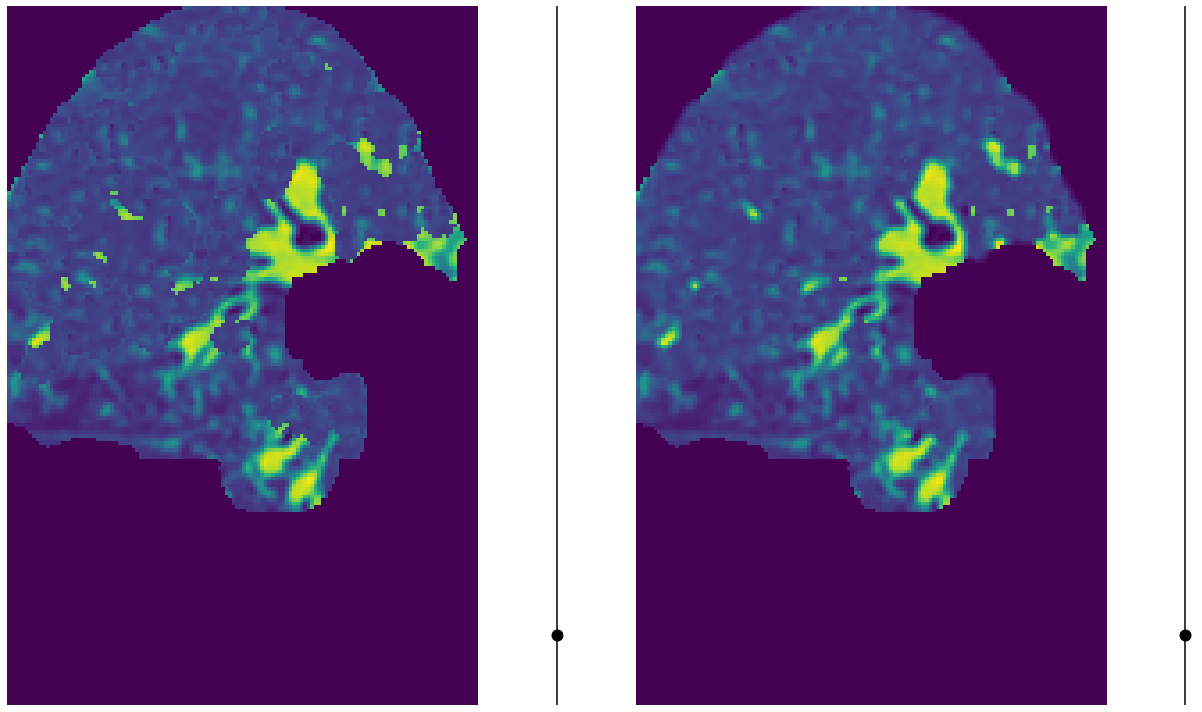

In [ ]:
##@title xx {vertical-output: true}
im_blend = copy(target_img_covid[...,SLICE])
mask_for_inpain = np.zeros_like(im_blend)
for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2] # add background texture with absolute coordinates
  im_blend[new_coords_mask] = texture[new_coords_mask] 

  mask_closed = binary_fill_holes(mask,)
  mask_in = (mask_closed).astype('int') - binary_erosion(mask_closed, iterations=iter_erosion_dilation)
  mask_out = binary_dilation(mask_closed, iterations=iter_erosion_dilation) - (mask_closed).astype('int')
  mask_ring = mask_in + mask_out

  new_coords_mask_inpain = np.where(mask_ring==1)[0]+coord[0], np.where(mask_ring==1)[1]+coord[2] # mask outer rings for inpaint
  mask_for_inpain[new_coords_mask_inpain] = 1 
  im_blend_inpain = inpaint.inpaint_biharmonic(im_blend, mask_for_inpain)


fig, ax = plt.subplots(1,4, gridspec_kw={'width_ratios': [30, 1,30,1]}, figsize=(18,10))
ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis')
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[1].scatter(0,GEN, c='k', s=120)
ax[1].set_ylim([0,100])
ax[2].imshow(im_blend_inpain[y_min: y_max, x_min: x_max], cmap='viridis')
ax[3].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[3].scatter(0,GEN, c='k', s=120)
ax[3].set_ylim([0,100])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

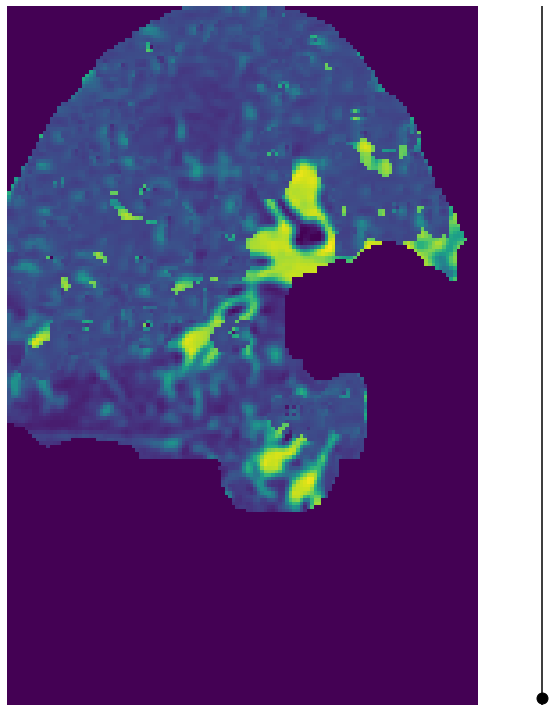

In [ ]:
##@title xx {vertical-output: true}
im_blend = copy(target_img_covid[...,SLICE])
GEN = 1
for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2] # add background texture with absolute coordinates
  im_blend[new_coords_mask] = texture[new_coords_mask] 
  new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2] # add cea syn with absolute coords
  im_blend[new_coords] = syn_norm[syn_norm>0] 

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10))
ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis')
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[1].scatter(0,GEN, c='k', s=120)
ax[1].set_ylim([0,100])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

## continue

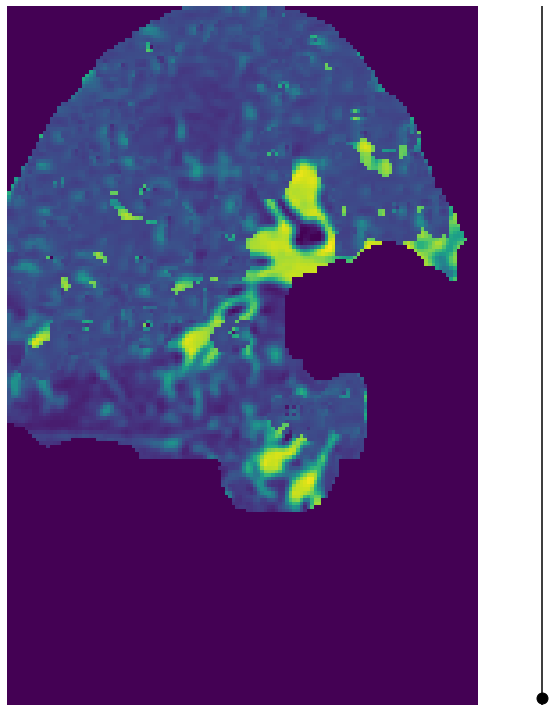

In [ ]:
#@title xx {vertical-output: true}
im_blend = copy(target_img_covid[...,SLICE])
GEN = 1
for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  # add background texture with absolute coordinates
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2]
  # im_blend[new_coords_mask] = mask[mask==1] *0
  im_blend[new_coords_mask] = texture[new_coords_mask]
  # add cea syn with absolute coords
  new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2]
  im_blend[new_coords] = syn_norm[syn_norm>0] 
  # im_blend[coord[0]:coord[1], coord[2]:coord[3]] = syn_norm

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10))
ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis')
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[1].scatter(0,GEN, c='k', s=120)
ax[1].set_ylim([0,100])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

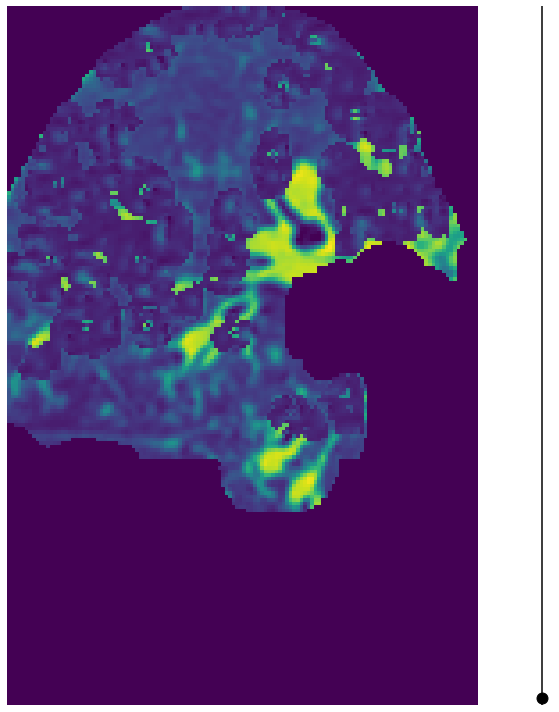

In [ ]:
#@title xx {vertical-output: true}
im_blend = copy(target_img_covid[...,SLICE])
GEN = 1
for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  # add background texture with absolute coordinates
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2]
  # im_blend[new_coords_mask] = mask[mask==1] *0
  im_blend[new_coords_mask] = texture[new_coords_mask]
  # add cea syn with absolute coords
  new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2]
  im_blend[new_coords] = syn_norm[syn_norm>0] 
  # im_blend[coord[0]:coord[1], coord[2]:coord[3]] = syn_norm

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10))
ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis')
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[1].scatter(0,GEN, c='k', s=120)
ax[1].set_ylim([0,100])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

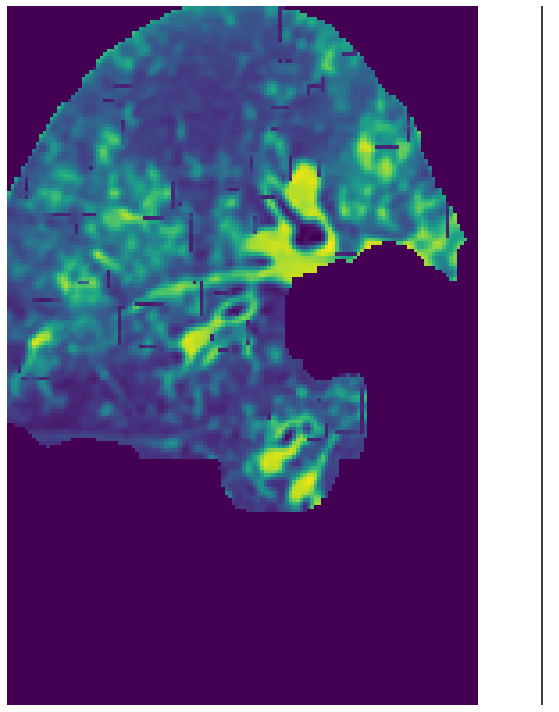

In [ ]:
#@title xx {vertical-output: true}
im_blend = copy(target_img_covid[...,SLICE])
GEN = -1
for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  # add background texture with absolute coordinates
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2]
  # im_blend[new_coords_mask] = mask[mask==1] *0
  im_blend[new_coords_mask] = texture[new_coords_mask]
  # add cea syn with absolute coords
  new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2]
  im_blend[new_coords] = syn_norm[syn_norm>0] 
  # im_blend[coord[0]:coord[1], coord[2]:coord[3]] = syn_norm

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10))
ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis')
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[1].scatter(0,GEN, c='k', s=120)
ax[1].set_ylim([0,100])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [ ]:
len(lesions_all[0])

256

In [ ]:
#@title make gif part1 {vertical-output: true}
images=[]
Path('images').mkdir(parents=True, exist_ok=True) 
file_path = "images/image.png"
im_blend = copy(target_img_covid[...,SLICE])
for GEN in tqdm(range(128)):
  for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
    syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
    syn_norm = syn_norm * mask
    # add background texture with absolute coordinates
    new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2]
    # im_blend[new_coords_mask] = mask[mask==1] *0
    im_blend[new_coords_mask] = texture[new_coords_mask]
    # add cea syn with absolute coords
    new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2]
    im_blend[new_coords] = syn_norm[syn_norm>0] 
    # im_blend[coord[0]:coord[1], coord[2]:coord[3]] = syn_norm

  fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10))
  ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis')
  ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
  ax[1].scatter(0,GEN, c='k', s=120)
  ax[1].set_ylim([0,len(lesion)])
  for axx in ax.ravel(): axx.axis('off')
  fig.tight_layout()
  plt.savefig(file_path); #Saves each figure as an image
  images.append(imageio.imread(file_path)); #Adds images to list
  plt.clf();
plt.close();

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

<Figure size 648x720 with 0 Axes>

In [ ]:
class IndexTracker:
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def on_scroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

In [ ]:
type(lesion)

numpy.ndarray

Using matplotlib backend: agg


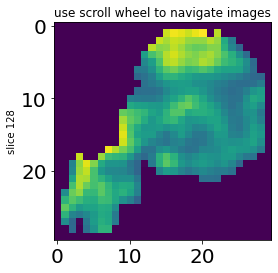

In [ ]:
%matplotlib
fig, ax = plt.subplots(1, 1)
tracker = IndexTracker(ax, np.moveaxis(lesion,0,-1))
fig.canvas.mpl_connect('scroll_event', tracker.on_scroll)
plt.show()

In [ ]:
# make gif part2 (use the list of images)
imageio.mimsave("images/covid_synthesis_clamp04.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display("images/covid_synthesis_clamp04.gif")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# make gif part2 (use the list of images)
imageio.mimsave("images/covid_synthesis_clamp2.gif", images, fps=4) #Creates gif out of list of images
mvp.ipython_display("images/covid_synthesis_clamp2.gif")

Output hidden; open in https://colab.research.google.com to view.

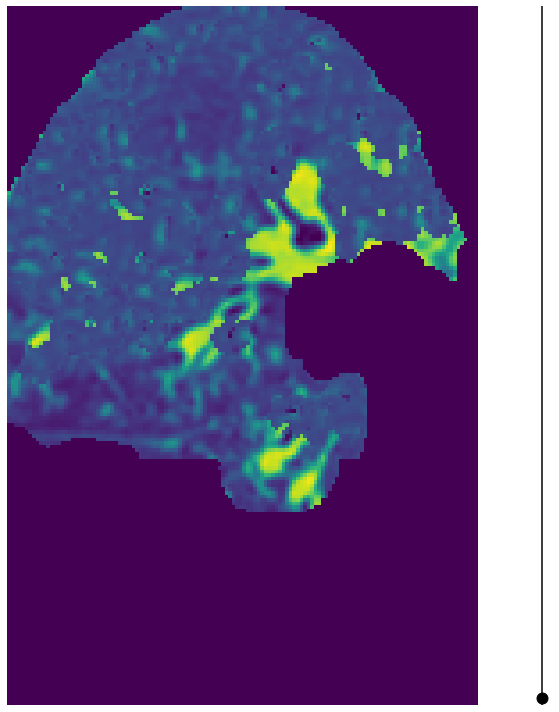

In [ ]:
#@title xx {vertical-output: true}
im_blend = copy(target_img_covid[...,SLICE])
GEN = 1
for lesion, coord, mask in zip(lesions_all, coords_all, masks_all):
  syn_norm = lesion[GEN]/255. # WARNING this might not be the best way to save the array (information lost)
  syn_norm = syn_norm * mask
  # add background texture with absolute coordinates
  new_coords_mask = np.where(mask==1)[0]+coord[0], np.where(mask==1)[1]+coord[2]
  # im_blend[new_coords_mask] = mask[mask==1] *0
  im_blend[new_coords_mask] = texture[new_coords_mask]
  # add cea syn with absolute coords
  new_coords = np.where(syn_norm>0)[0]+coord[0], np.where(syn_norm>0)[1]+coord[2]
  im_blend[new_coords] = syn_norm[syn_norm>0] 
  # im_blend[coord[0]:coord[1], coord[2]:coord[3]] = syn_norm

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [30, 1]}, figsize=(9,10))
ax[0].imshow(im_blend[y_min: y_max, x_min: x_max], cmap='viridis')
ax[1].vlines(x=0, ymin=0, ymax=len(lesion), color='k')
ax[1].scatter(0,GEN, c='k', s=120)
ax[1].set_ylim([0,100])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

## TODO
- increase the iterations of the inner loop progresively   
- Start with good training, then when it's properly trained switch to growig the mask ocasionally   
- put a mask on the loss to focus on the are grown (and maybe a little more using dilations?)      
- use distance transform to give a weighted mask   
- CLAMP THE NEW ALIVE PIXELS TO THE VALUES OF THE INPAINTED VERSION   